In [1]:
#core scverse
import numpy as np
import scanpy as sc
import anndata as ad

#data retrieval
import pooch

In [2]:
sc.settings.set_figure_params(dpi=50, facecolor="white")


In [3]:
EXAMPLE_DATA = pooch.create(
    path=pooch.os_cache("scverse_tutorials"),
    base_url="doi:10.6084/m9.figshare.22716739.v1/",
)
EXAMPLE_DATA.load_registry_from_doi()

### pooch로 data 받을 디렉토리 만들고
### doi에서 registry file (다운받을 data 파일명 목록)

In [4]:
print(EXAMPLE_DATA.registry_files)

['s1d1_filtered_feature_bc_matrix.h5', 's1d3_filtered_feature_bc_matrix.h5']


In [5]:
samples = {
    "s1d1": "s1d1_filtered_feature_bc_matrix.h5",
    "s1d3": "s1d3_filtered_feature_bc_matrix.h5",
}
### samples = {"sample_id" : "filename"}
### sample_id (local ID)와 filename이 매칭된 파일

adatas = {}
### AnnData 담을 리스트 생성

for sample_id, filename in samples.items():
    path = EXAMPLE_DATA.fetch(filename)
    ### 해당 파일명을 다운받음
    
    sample_adata = sc.read_10x_h5(path)
    ### scanpy의 read_10x_h5로 hdf5파일을 읽어서 AnnData object를 만든다
    ### AnnData는 .X (exp. matrix), .obs_names (cell metadata), .var_names (gene metadata)
    ### 후술하지만, .var은 .var_names와 달리 메타데이터. 
    
    sample_adata.var_names_make_unique()
    ### Makes sure all gene names are unique
    ### Important because some gene annotations may appear multiple times
    
    adatas[sample_id] = sample_adata
    ### 만든 AnnData object를 리스트에 저장

adata = ad.concat(adatas, label="sample")
adata.obs_names_make_unique()
print(adata.obs["sample"].value_counts())
adata

/root/miniconda/envs/unified_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/root/miniconda/envs/unified_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


sample
s1d1    8785
s1d3    8340
Name: count, dtype: int64


/root/miniconda/envs/unified_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/root/miniconda/envs/unified_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/root/miniconda/envs/unified_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


AnnData object with n_obs × n_vars = 17125 × 36601
    obs: 'sample'

In [6]:
#QC

# mitochondrial genes, "MT-" for human, "Mt-" for mouse
adata.var["mt"] = adata.var_names.str.startswith("MT-")
# ribosomal genes
adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))
# hemoglobin genes
adata.var["hb"] = adata.var_names.str.contains("^HB[^(P)]")

### adata.var_names: 유전자 이름(열 인덱스).
### .str.startswith(...), .str.contains(...): pandas의 벡터화 문자열 메서드 
### → 유전자명 전체에 대해 한 번에 불리언 시리즈를 만듭니다.
### 해당 문자열로 시작하는 var_names를 불리언 컬럼으로 만들어
### gene metadata를 저장하는 adata.var에 저장. 
### var_names에서 하나씩 검색하는 것이 아니라, 필요한 애들만 메타데이터로 따로 저장하면
### QC할때 바로 검색할 수 있어서 편함.

sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt", "ribo", "hb"], inplace=True, log1p=True
)

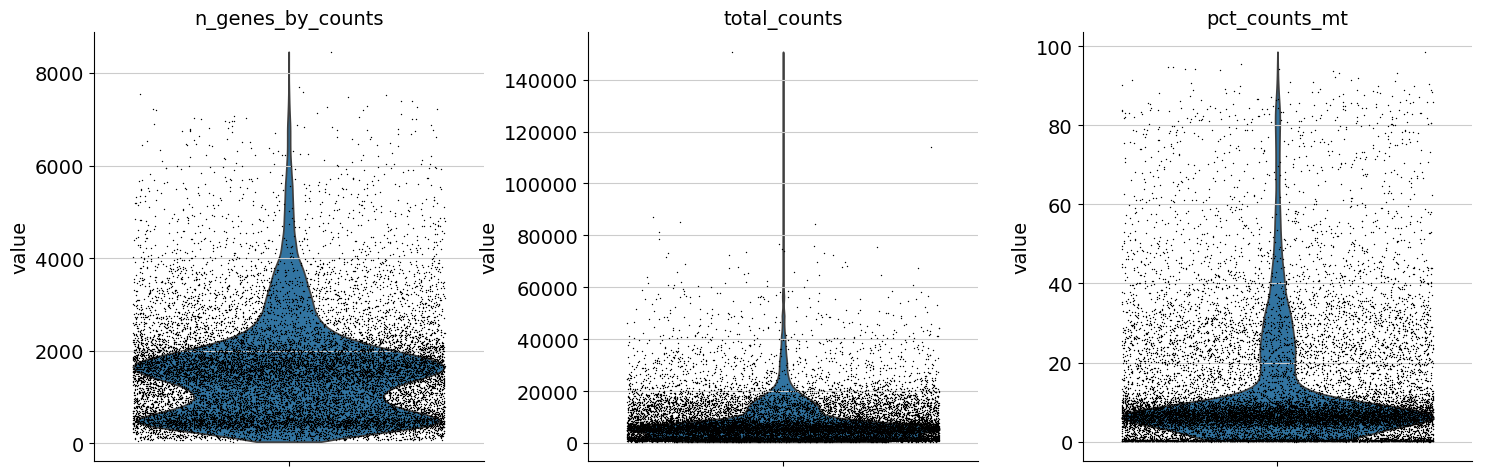

In [7]:
# VIsualization - Violin Plot
## 1.the number of genes expressed in the count matrix
## 2.the total counts per cell
## 3.the percentage of counts in mitochondrial genes

sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4, ### Horizontal random displacement level
    multi_panel=True,
)

## 1. value 작은 애들은 cell 당 gene count가 적은 dead cell, 크면 doublet
## 2. total count 작은 애들은 sequencing depth가 얕아 증폭 덜 됨. 크면 doublet
## 3. mito count 큰 애들은 dead cell이므로 제외

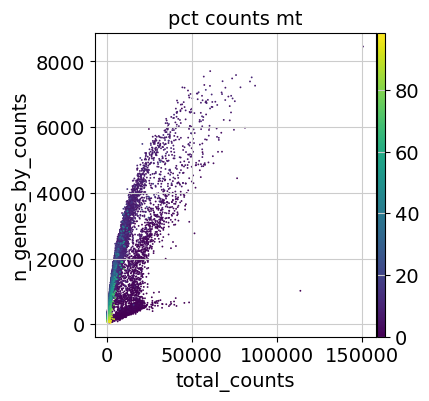

In [8]:
sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

## gene_by_count, total_counts에서 바운더리를 정하고, pct_counts_mt 색으로 필터링
## gene_by_count와 total_count가 너무 작은 애들은 대부분 pct_counts 높은 dead cell임

In [9]:
sc.pp.filter_cells(adata, min_genes=100)
sc.pp.filter_genes(adata, min_cells=3)

## 일단은 lose boundary로 접근

In [10]:
sc.pp.scrublet(adata, batch_key="sample", mean_center = False)


### 간단히 말해서, scrublet은 ARPACK으로 PCA에 필요한 top k eigenvalue만 리턴
### n_prin_comps 의 디폴트값은 30. 만약 한 batch에 30보다 작은 cell이 있다면 오류


In [12]:
# store preprocessed data

from pathlib import Path
Path("cache").mkdir(exist_ok = True)
adata.write("cache/tut_preproc.h5ad")